# **Bearing failure Anomaly Detection**  

---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* Session 1 - 「Data 전처리 및 EDA」
* Session 2 - 「시계열 데이터 특성 추출」
* Session 3 - 「이상 탐지 모델링」

In [1]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# 데이터 분석을 위한 기초 라이브러리 호출 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 

```
A사는 냉장고를 생산하는 업체임.냉장고 제작 공정은 컨베이어 벨트 방식으로 제작이 되며, 
하나의 공정이 중단될 시 모든 공정이 All stop됨.
냉장고를 제작하는데 있어 주요 공정인 A 설비는 Bearing을 핵심 부품으로 사용함.
Bearing은 사용할 수록 마모가 되어 주기적으로 변경을 해줘야함.
A사는 Bearing이 파손되기 이전에 이상점을 감지하여 사전 유지보수를 통해 All stop을 사전에 방지하고자 함.

요지) Bearing 파손 탐지 모델을 개발하고 이상점을 탐지할 것
```  

> **데이터 살펴보기**

* Bearing Sensor data
* 데이터 명세 ⬇ 

|Column|Description|
|:---|:---|
|index|측정 시간 Index|
|Bearing 1|베어링 1 진동 센서 값|
|Bearing 2|베어링 2 진동 센서 값|
|Bearing 3|베어링 3 진동 센서 값|
|Bearing 4|베어링 4 진동 센서 값|




In [4]:
# pd.set option
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)  

# Data read
df = pd.read_csv("Averaged_BearingTest_Dataset.csv")
df.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [5]:
df.columns = ['time', 'Bearing1',	'Bearing2'	,'Bearing3',	'Bearing4']
df.head()

,time,Bearing1,Bearing2,Bearing3,Bearing4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659



## **문제해결 프로세스 정의**
---
> **문제정의**

```
냉장고 공정 주요 설비 A의 고장이 발생하면 Line All stop 리스크
A 설비의 핵심 부품인 Bearing 마모에 따른 설비 고장
```  

> **기대효과**

```
설비고장 사전에 방지하여, Line stop 방지
Line stop으로 인한 점검 시감 및 비용 절감
계획 대비 생산량 달성
```

> **해결방안**

```
Bearing Sensor data 이상 탐지를 통해 사전고장발생 방지
Session 1 
 - Data 전처리 및 EDA
Session 2 
 - 시계열 데이터 특성을 추출
Session 3 
 - 이상 탐지 모델링 수행
```

> **성과측정**  

```
모델 활용 전/후 Line stop 횟수 비교
모델 활용 전/후 계획 대비 생산률 비교
```

> **현업적용**  



```
Bearing Sensor Data 실시간 수집 체계 구축
Model에 Input할 window time 결정
Sensor Data Model Input 및 Anomaly Detection
Anomaly Points 발견 시 유휴시간 장비 점검
```

> **주요 코드 미리 살펴보기**  

```
Session 1 → pd.to_datetime(), set_index(), df.index.name=''
Session 2 → x.year, x.month, x.day..., sns.boxplot(), .shift(1), rolling(window=3).mean() 
Session 3 → StandardScaler(), PCA(), make_pipeline(scaler,pca)
```

## **Session 1: Data 전처리 및 EDA**  

---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태), Data type 확인 : 데이터 타입 변환을 통한 전처리

  (2) Null값 확인 (※ 빈 값의 Data): 결측치 처리 수행

  (3) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)

In [6]:
# Data 형태 확인
# 982 row, 5 col로 구성됨
print('df :', df.shape)

df : (982, 5)


In [7]:
# Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      982 non-null    object 
 1   Bearing1  982 non-null    float64
 2   Bearing2  982 non-null    float64
 3   Bearing3  982 non-null    float64
 4   Bearing4  982 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.5+ KB


In [8]:
# Null 값 확인
print(df.isnull().sum())

time        0
Bearing1    0
Bearing2    0
Bearing3    0
Bearing4    0
dtype: int64


In [9]:
# Outlier 확인
df.describe()

,Bearing1,Bearing2,Bearing3,Bearing4
count,982.000000,982.000000,982.000000,982.000000
mean,0.080951,0.078543,0.081351,0.047830
std,0.040200,0.011789,0.011607,0.009549
min,0.001168,0.000767,0.000716,0.001699
25%,0.060773,0.074240,0.076829,0.043951
50%,0.062021,0.075206,0.078187,0.044524
75%,0.083277,0.077458,0.080575,0.048130
max,0.453335,0.161016,0.151299,0.119047


### · Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [10]:
df.head()

,time,Bearing1,Bearing2,Bearing3,Bearing4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [11]:
# 시간형태 데이터 타입 변경 및 Index 설정
df['time'] = pd.to_datetime(df['time'])
df.set_index('time',inplace=True)

In [12]:
# Index name 변경
df.index.name=''

In [13]:
df.head()

,Bearing1,Bearing2,Bearing3,Bearing4
,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [14]:
# 전체 Data 기간 확인
df.index.min(), df.index.max()

(Timestamp('2004-02-12 10:52:39'), Timestamp('2004-02-19 06:22:39'))

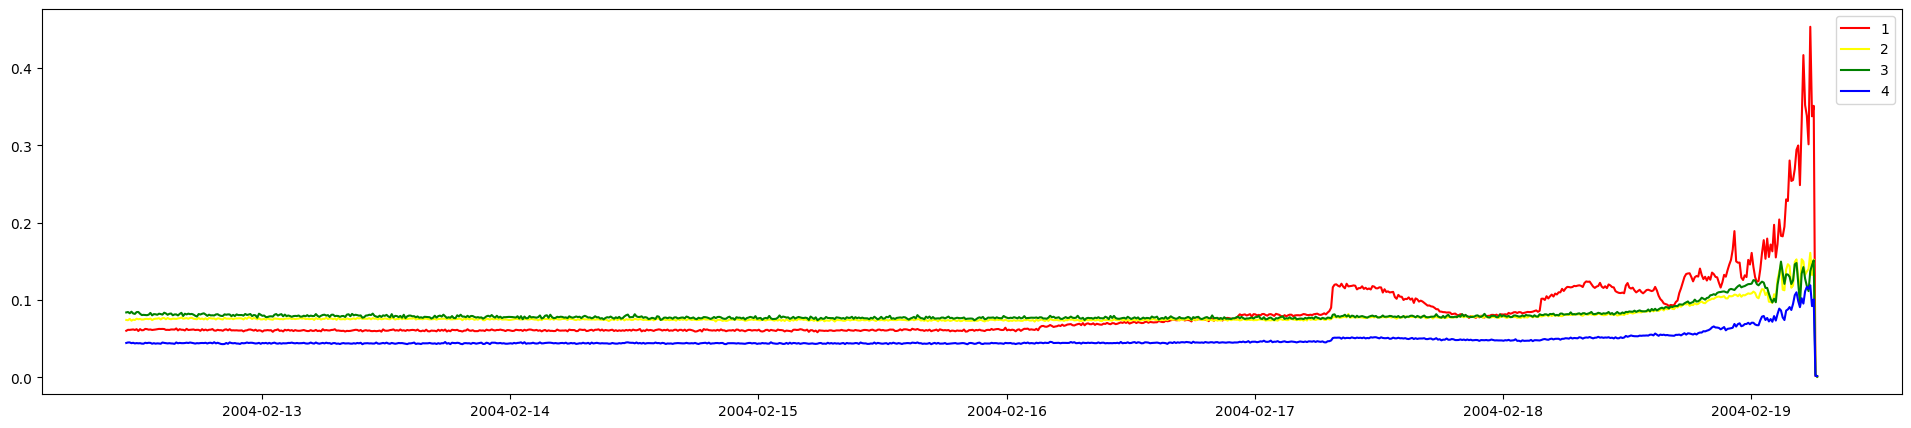

In [15]:
# Plotting 전체 데이터 
%matplotlib inline
plt.figure(figsize=(24,5))
plt.plot(df.index, df['Bearing1'], linestyle='-', color='red', label='1');
plt.plot(df.index, df['Bearing2'], linestyle='-', color='yellow', label='2');
plt.plot(df.index, df['Bearing3'], linestyle='-', color='green', label='3');
plt.plot(df.index, df['Bearing4'], linestyle='-', color='blue', label='4');
plt.legend();

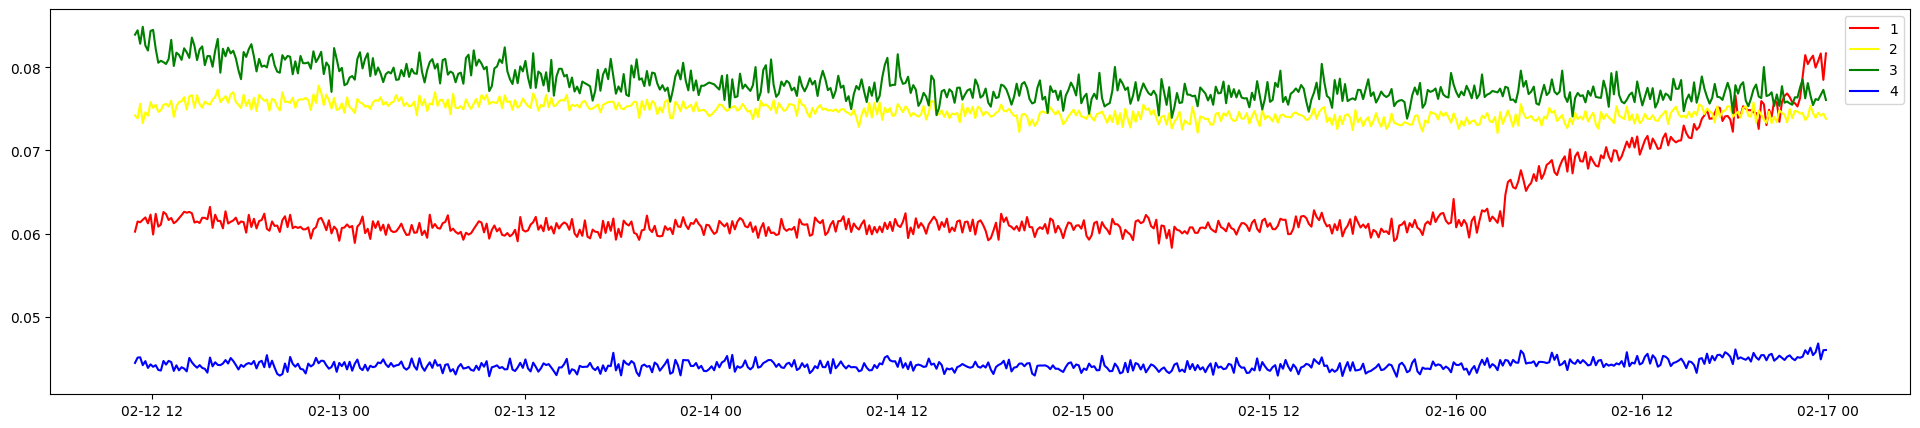

In [16]:
# 솟구치기전 데이터
df_before = df[:'2004-02-17 00:00:00']

plt.figure(figsize=(24,5))
plt.plot(df_before.index, df_before['Bearing1'], linestyle='-', color='red', label='1');
plt.plot(df_before.index, df_before['Bearing2'], linestyle='-', color='yellow', label='2');
plt.plot(df_before.index, df_before['Bearing3'], linestyle='-', color='green', label='3');
plt.plot(df_before.index, df_before['Bearing4'], linestyle='-', color='blue', label='4');
plt.legend();

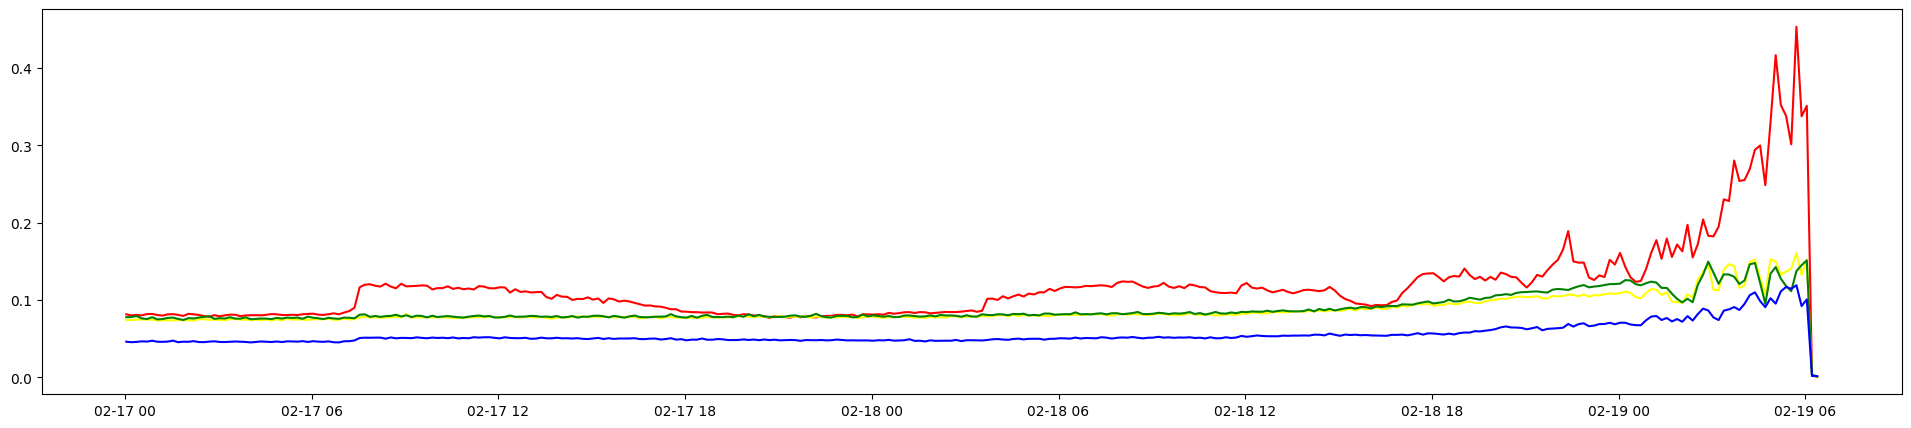

In [17]:
# After Data 기간 확인
df_after = df['2004-02-17 00:00:00':]

plt.figure(figsize=(24,5))
plt.plot(df_after.index, df_after['Bearing1'], linestyle='-', color='red', label='1');
plt.plot(df_after.index, df_after['Bearing2'], linestyle='-', color='yellow', label='2');
plt.plot(df_after.index, df_after['Bearing3'], linestyle='-', color='green', label='3');
plt.plot(df_after.index, df_after['Bearing4'], linestyle='-', color='blue', label='4');

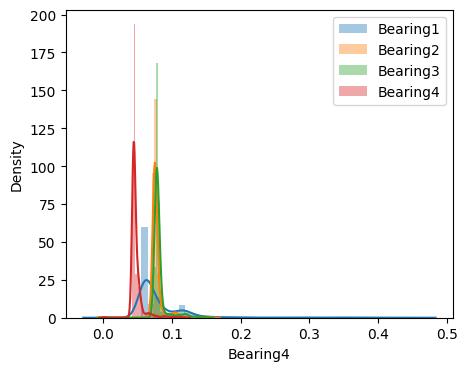

In [30]:
plt.figure(figsize=(5, 4))
sns.distplot(df['Bearing1'], label='Bearing1')
sns.distplot(df['Bearing2'], label='Bearing2')
sns.distplot(df['Bearing3'], label='Bearing3')
sns.distplot(df['Bearing4'], label='Bearing4')
plt.legend()

## **Session 2: 이상 탐지 모델링**  
---

### · Model Selection
---
* PCA Anomaly Detection
```
# 여러 변수 간에 존재하는 상관관계를 이용하여 이를 대표한 주성분을 추출해 차원을 축소하는 기법
# 기존 데이터의 유실을 최소하 하기 위해 데이터의 분산을 최대화 할 수 있는 초평면(Hyper plane)을 찾고 데이터를 투영함
# Auto encoder와 작동원리가 비슷함
# 다중공선성을 제거하기 위해 각 벡터의 축이 직각이 되도록 투영 시킴
# 원본 데이터의 Feature 개수에 비해 매우 적은 주성분으로 원본 데이터의 총 변동성을 대부분 설명할 수 있는 분석법
```
<img src = "https://drive.google.com/uc?id=16dNJTSMUiFmk4wQtJ7hP3HmL0wUy1vgP">

* 장단점
```
  # [good] 고차원에 데이터를 저차원에 주성분으로 표현할 수 있음
  # [good] 선택한 변수들의 해석이 용이함
  # [bad] 변수간 상관관계 고려가 어려움 
  # [bad] 추출된 변수의 해석이 어려움 (※ 주성분, PC1/PC2 ...)
```

### · 차원축소 및 변수 설명력 확인
---

In [31]:
df.head()

,Bearing1,Bearing2,Bearing3,Bearing4
,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df = df[['Bearing1', 'Bearing2', 'Bearing3', 'Bearing4']]


# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(df)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

In [33]:
# pca.n_components_(차원 축소 주성분 개수)
features = range(pca.n_components_)
feature_df=pd.DataFrame(data=features,columns=['pc_feature'])

# pca.explained_variance_ratio_(설명력)
variance_df=pd.DataFrame(data=pca.explained_variance_ratio_,columns=['variance'])
pc_feature_df=pd.concat([feature_df,variance_df],axis=1)
pc_feature_df

# PC0, PC1으로도 전체 분산에 95% 이상 설명 가능

,pc_feature,variance
0,0,0.935243
1,1,0.052920
2,2,0.007789
3,3,0.004048


### · 시각화 및 Threshold 선정
---





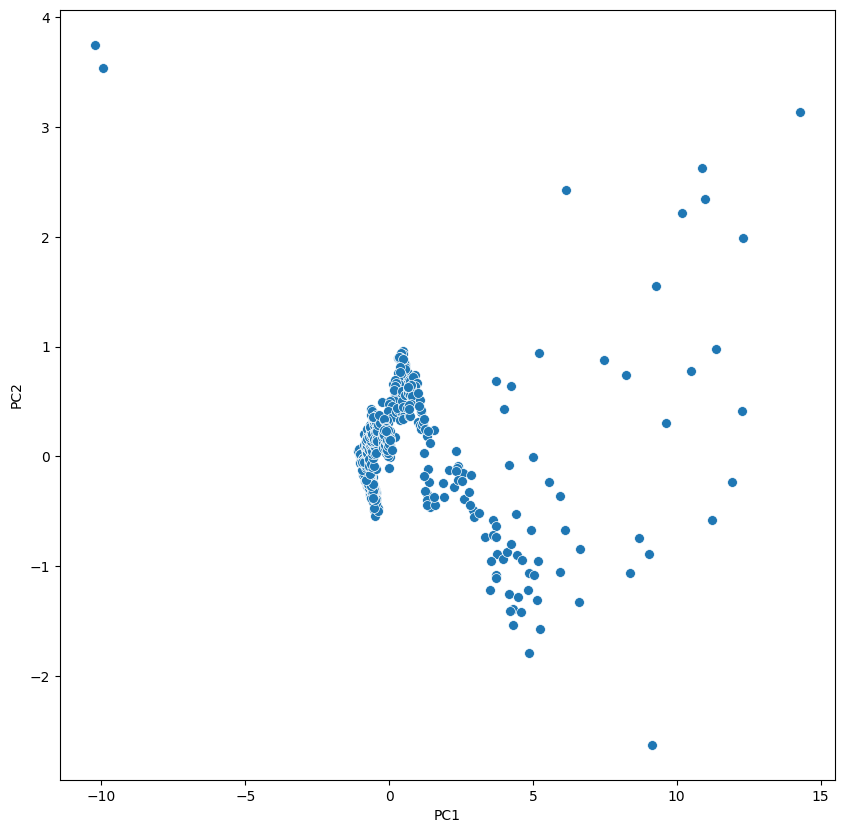

In [34]:
%matplotlib inline

# 정규화
X_ = StandardScaler().fit_transform(df)

# 2개의 주성분으로 차원 축소
pca = PCA(n_components=2)
pc = pca.fit_transform(X_)

pc_df=pd.DataFrame(pc,columns=['PC1', 'PC2']).reset_index(drop=True)

plt.rcParams['figure.figsize'] = [10, 10]
sns.scatterplot(data=pc_df,x='PC1',y='PC2', legend='brief', s=50, linewidth=0.5);

# 각 클러스터 중심에서 멀리 떨어진 Data 일 수록 이상치

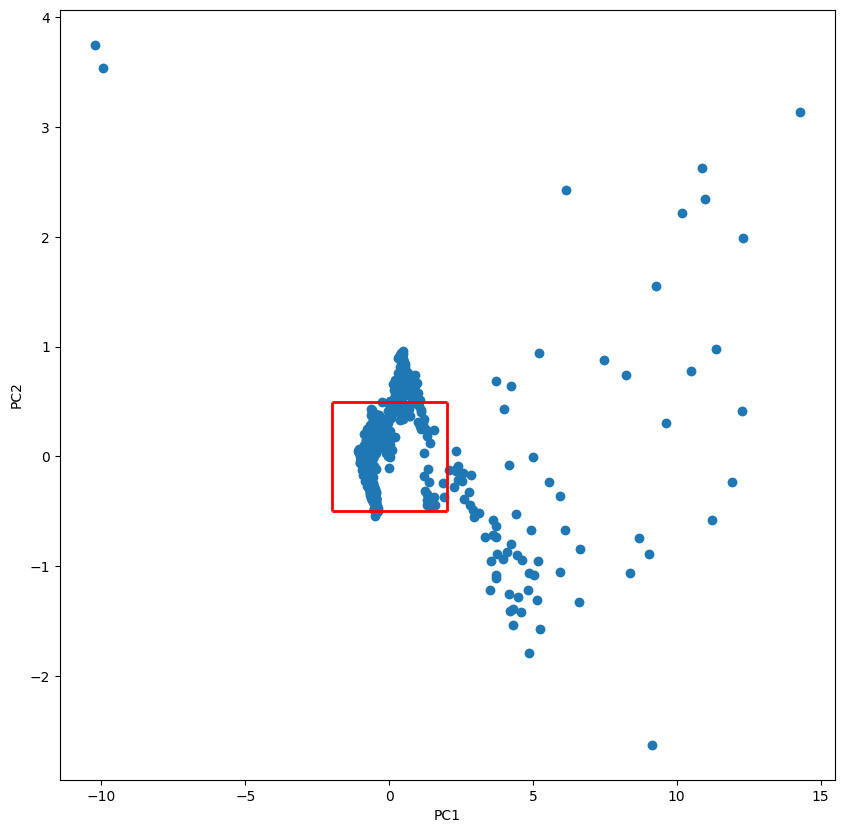

In [35]:
# PC1, PC2인 차원 축소 변수 2, -2를 기준으로 등급을 부여

sns.scatterplot(data=pc_df,x='PC1',y='PC2', s=50, linewidth=0);

# Normal grade
plt.vlines(-2, ymin=-0.5, ymax=0.5, color='r', linewidth=2);
plt.vlines(2, ymin=-0.5, ymax=0.5, color='r', linewidth=2);

plt.hlines(-0.5, xmin=-2, xmax=2, color='r', linewidth=2);
plt.hlines(0.5, xmin=-2, xmax=2, color='r', linewidth=2);

plt.gcf().set_size_inches(10, 10)

### · Abnormal Labeling
---





In [36]:
# np.where 활용 if문 
pc_df['abnormal'] = np.where( (pc_df['PC1']>-2) & (pc_df['PC1']<2) & (pc_df['PC2']>-0.5) & (pc_df['PC2']<0.5), 0, 1)
pc_df.head(5)

,PC1,PC2,abnormal
0,-0.509598,-0.478672,0
1,-0.454730,-0.465373,0
2,-0.446235,-0.416285,0
3,-0.507399,-0.490065,0
4,-0.516699,-0.381590,0


In [37]:
pc_df['abnormal'].value_counts()

0    813
1    169
Name: abnormal, dtype: int64

In [38]:
# 기존 Data의 index를 부여
pc_df.index = df.index
pc_df.head()

,PC1,PC2,abnormal
,,,
2004-02-12 10:52:39,-0.509598,-0.478672,0
2004-02-12 11:02:39,-0.454730,-0.465373,0
2004-02-12 11:12:39,-0.446235,-0.416285,0
2004-02-12 11:22:39,-0.507399,-0.490065,0
2004-02-12 11:32:39,-0.516699,-0.381590,0


In [39]:
# 기존 data와 Concat
df_concat = pd.concat([df, pc_df], axis=1)
df_concat.head()

,Bearing1,Bearing2,Bearing3,Bearing4,PC1,PC2,abnormal
,,,,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,-0.509598,-0.478672,0
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,-0.454730,-0.465373,0
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,-0.446235,-0.416285,0
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172,-0.507399,-0.490065,0
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659,-0.516699,-0.381590,0


### · 모델 평가
---





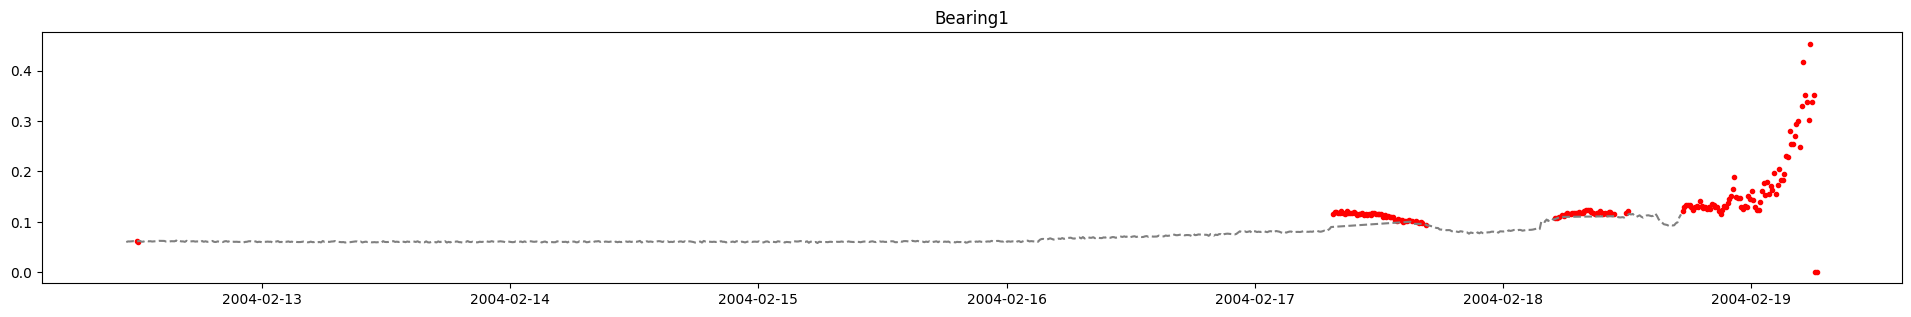

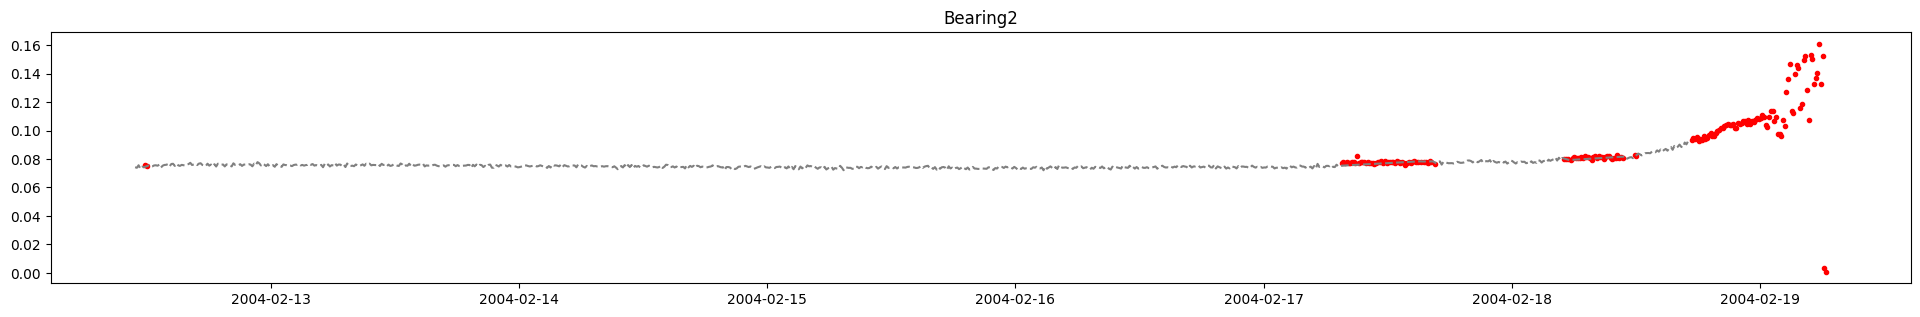

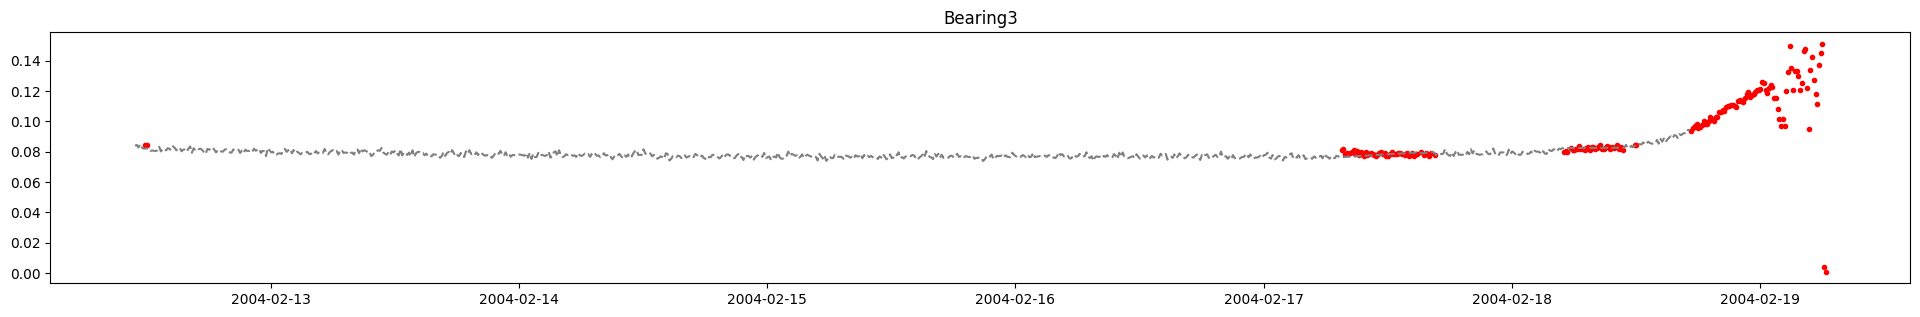

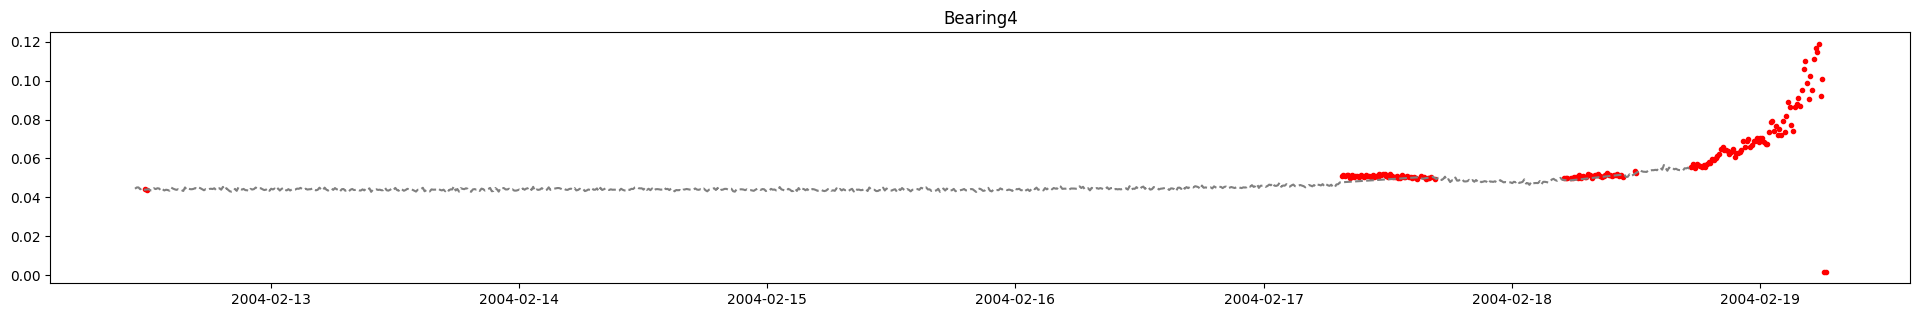

In [40]:
# Anomaly Points Plot

df_abnormal = df_concat[df_concat['abnormal']==1]
df_normal = df_concat[df_concat['abnormal']==0]

for v, i in  enumerate(df.columns[0:4]) :
    plt.figure(figsize=(24,15))
    plt.subplot(4, 1, v+1)
    plt.plot(df_abnormal.index, df_abnormal[i], 'o', color='red', markersize=3);
    plt.plot(df_normal.index, df_normal[i], linestyle='--', color='grey');
    plt.title(i)